# pre-requisites

In [32]:
# sets *your* project id
PROJECT_ID = "esicmdatathon2024" #@param {type:"string"}


In [33]:
# sets default dataset for AmsterdamUMCdb
DATASET_PROJECT_ID = 'amsterdamumcdb' #@param {type:"string"}
DATASET_ID = 'version1_5_0' #@param {type:"string"}
LOCATION = 'eu' #@param {type:"string"}

In [34]:
import os
from google.colab import auth

# all libraries check this environment variable, so set it:
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

auth.authenticate_user()
print('Authenticated')


Authenticated


In [35]:
%load_ext google.colab.data_table
from google.colab.data_table import DataTable

# change default limits:
DataTable.max_columns = 50
DataTable.max_rows = 30000


The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [36]:
from google.cloud.bigquery import magics
from google.cloud import bigquery

# sets the default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset=DATASET_PROJECT_ID + "." + DATASET_ID)
magics.context.default_query_job_config = def_config


# Platelet Baseline

In [37]:
# get the baseline platelet count from first blood results
%%bigquery all_plat_baseline --project esicmdatathon2024
SELECT m.visit_occurrence_id, measurement_datetime
  , case when value_as_number between 100 and 149 then 1 -- mild
         when value_as_number between 50 and 99 then 2 -- moderate
         when value_as_number between 20 and 49 then 3 -- severe
         when value_as_number < 20 then 4 -- very severe
         else 0  -- normal, no thrombocytopenia
    end as value_baseline
  FROM measurement m
  inner join specimen s
        on m.person_id = s.person_id
        and m.measurement_datetime = s.specimen_datetime
        and s.specimen_concept_id in (4047496 -- arterial only!
        )
  WHERE
    NOT provider_id IS NULL -- ignore unvalidated device data
    and measurement_concept_id = 3007461 -- Platelets [#/volume] in Blood
    and m.measurement_type_concept_id = 32856 -- lab
  qualify row_number() over(partition by visit_occurrence_id order by measurement_datetime) = 1

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: xlabel='value_baseline', ylabel='Count'>

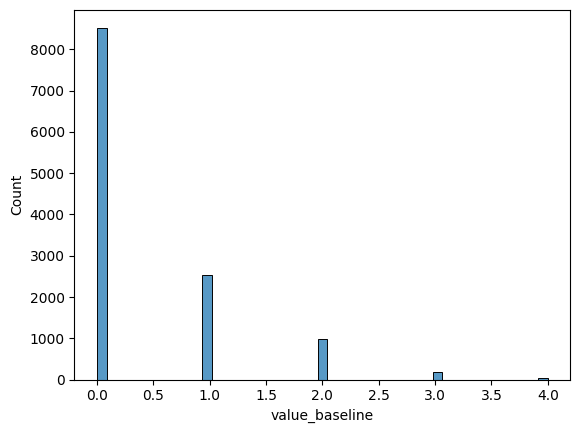

In [38]:
import seaborn as sns
sns.histplot(all_plat_baseline.value_baseline)

In [39]:
%%bigquery all_plat_exit --project esicmdatathon2024
SELECT visit_occurrence_id --, measurement_datetime
  , case when value_as_number between 100 and 149 then 1 -- mild
         when value_as_number between 50 and 99 then 2 -- moderate
         when value_as_number between 20 and 49 then 3 -- severe
         when value_as_number < 20 then 4 -- very severe
         else 0  -- normal, no thrombocytopenia
    end as value_exit
  FROM measurement m
  inner join specimen s
        on m.person_id = s.person_id
        and m.measurement_datetime = s.specimen_datetime
        and s.specimen_concept_id in (4047496 -- arterial only!
        )
  WHERE
    NOT provider_id IS NULL -- ignore unvalidated device data
    and measurement_concept_id = 3007461 -- Platelets [#/volume] in Blood
    and m.measurement_type_concept_id = 32856 -- lab
  qualify row_number() over(partition by visit_occurrence_id order by measurement_datetime desc) = 1


Query is running:   0%|          |

Downloading:   0%|          |

<Axes: xlabel='value_exit', ylabel='Count'>

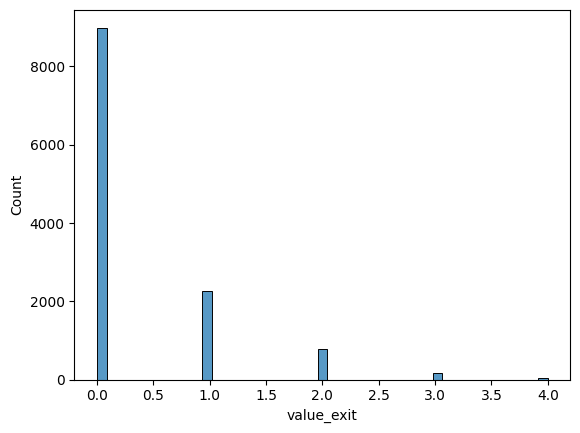

In [40]:
sns.histplot(all_plat_exit.value_exit)

In [41]:
data = all_plat_baseline.merge(all_plat_exit, how='inner', left_on='visit_occurrence_id', right_on='visit_occurrence_id')


In [42]:
data = data.groupby(['value_baseline', 'value_exit']).size().reset_index().rename(columns={0:'count'})
data


,value_baseline,value_exit,count
0,0,0,7893
1,0,1,486
2,0,2,122
3,0,3,24
4,0,4,4
5,1,0,876
6,1,1,1472
7,1,2,162
8,1,3,26
9,1,4,4


In [43]:
import pandas as pd
import plotly.graph_objects as go



In [44]:
#for assigning unique number to each source and target
mapping_dict_baseline = {0: "Normal", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Very Severe"}
mapping_dict_exit = {0: "_Normal", 1: "_Mild", 2: "_Moderate", 3: "_Severe", 4: "_Very Severe"}


In [45]:
data['source'] = data['value_baseline'].map(mapping_dict_baseline)
data['target'] = data['value_exit'].map(mapping_dict_exit)


In [46]:
data

,value_baseline,value_exit,count,source,target
0,0,0,7893,Normal,_Normal
1,0,1,486,Normal,_Mild
2,0,2,122,Normal,_Moderate
3,0,3,24,Normal,_Severe
4,0,4,4,Normal,_Very Severe
5,1,0,876,Mild,_Normal
6,1,1,1472,Mild,_Mild
7,1,2,162,Mild,_Moderate
8,1,3,26,Mild,_Severe
9,1,4,4,Mild,_Very Severe


In [47]:
#for using with 'label' parameter in plotly
unique_source_target = list(pd.unique(data[['source', 'target']].values.ravel('K')))

#for assigning unique number to each source and target
mapping_dict = {k: v for v, k in enumerate(unique_source_target)}


In [48]:
mapping_dict

{'Normal': 0,
 'Mild': 1,
 'Moderate': 2,
 'Severe': 3,
 'Very Severe': 4,
 '_Normal': 5,
 '_Mild': 6,
 '_Moderate': 7,
 '_Severe': 8,
 '_Very Severe': 9}

In [49]:
#mapping of full data
data['source'] = data['source'].map(mapping_dict)
data['target'] = data['target'].map(mapping_dict)


In [50]:
#converting full dataframe as list for using with in plotly
links_dict = data.to_dict(orient='list')


In [51]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = unique_source_target,
      color = ['royalblue', 'yellow', 'orange', 'red', 'purple', 'royalblue', 'yellow', 'orange', 'red', 'purple']
    ),
    link = dict(
      source = links_dict['source'],
      target = links_dict['target'] ,
      value = links_dict['count']
  ))])

fig.update_layout(title_text="baseline to exit platelet count (all)", font_size=10)
fig.show()
fig.write_html("sankey.html")